# Analyze Data for Capstone Project

### Python libraries to analyze stock data

After checking numerous python libraries dedicated to time series analysis, I have used the below libraries which are fairly comprehensive and widely used:<br>
<ul>
<li>Libraries to analyze time series stationarity, co-relation, ACF/PACF: statsmodels, pmdarima</li>
<li>Libraries to analyze time series seasonality using seasonal decompose: statsmodels, pmdarima</li>
<li>Libraries for timeseries forecasting: statsmodels(HWES), pmdarima, fbprophet</li>
<li>Libraries for accuracy metrics: sklearn, pmdarima(SMAPE)</li>
</ul>

In [1]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 

%matplotlib inline

Probable seasonal stocks <br>
Summers:	Voltas, Hitachi, Whirlpool, Vadilal, Bluestar, Varun Beverages, Havells, Manpasand Beverage<br>
Rainy:	    Kaveri Seed, Dhanuka Agritech, UPL, Chambal Fertilizers, Escorts, M&M, Swaraj Engines, Shakti Pumps, Deepak Fertilizers, RCF, Tata Chemicals<br>
Winter:	    Tata Global Bev, Bombay Burmah, CCL Products, Tata Coffee, Mcleod Russel <br>
Budget: 	Railways, Education, Agro Based Stocks like Titagarh Wagons, Texmaco Rail, Stone India <br>
Festival:   Hero MotoCorp, Maruti Suzuki, TITAN, PC Jewellers, United Spirits<br>

Stock ticker of seasonal stocks <br>
<br>Voltas - VOLTAS
<br>Hitachi - JCHAC
<br>Whirlpool - WHIRLPOOL
<br>Vadilal - VADILALIND
<br>Bluestar - BLUESTARCO
<br>Chambal - CHAMBLFERT
<br>Deepak - DEEPAKFERT
<br>RCF - RCF
<br>Tata Chemicals - TATACHEM
<br>Titan - TITAN
<br>Tata Coffee - TATACOFFEE
<br>Mcloed Russel - MCLEODRUSS
<br>Varun Beverages - VBL

In [2]:
#Initialize the common variables
source_dir =  r'.\data\rawdata' + '\\'
transformed_dir =  r'.\data\inputdata' + '\\'
stock_tickers = ['VOLTAS', 'CHAMBLFERT', 'TATACOFFEE', 'MARUTI']
rolling_window = 5
min_train_data_years = 5
min_cross_val = 3
max_cross_val = 5
min_years_data_reqd = min_train_data_years + min_cross_val
now = datetime.datetime.now()

In [3]:
stock_ticker = stock_tickers[0]
stock_ticker

'VOLTAS'

### Load the stock data

In [4]:
#Select required columns from csv
#data = pd.read_csv(source_dir + stock_ticker + ".csv", index_col=0, usecols=['Date', 'Adj Close'], parse_dates=True)
data = pd.read_csv(source_dir + stock_ticker + ".csv", index_col=0, parse_dates=True)
#Sort data by date
data = data.sort_index(ascending = True)
data.index.names = ['date']
data = data.rename(columns={"Adj Close": "adj_close"})
data.head()

,High,Low,Open,Close,Volume,adj_close
date,,,,,,
2002-07-01,0.590,0.570,0.570,0.587,168220.0,-0.661381
2002-07-02,0.590,0.578,0.581,0.582,143040.0,-0.655747
2002-07-03,0.594,0.573,0.594,0.578,99480.0,-0.651241
2002-07-04,0.581,0.561,0.580,0.570,213060.0,-0.642227
2002-07-05,0.580,0.561,0.571,0.565,168870.0,-0.636593


In [5]:
years_of_data = len(data.index.year.unique()) - 1 ##-1 for removing current year
years_of_data

18

In [6]:
# Check min. data required for forecasting
# Aprox. 250 days in a year
if (years_of_data < min_years_data_reqd):
    data = data.dropna(how = 'all')
    print("Data is not sufficient for analysis")  

### Validate and cleanse the stock data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4481 entries, 2002-07-01 to 2020-08-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       4481 non-null   float64
 1   Low        4481 non-null   float64
 2   Open       4481 non-null   float64
 3   Close      4481 non-null   float64
 4   Volume     4481 non-null   float64
 5   adj_close  4481 non-null   float64
dtypes: float64(6)
memory usage: 245.1 KB


In [8]:
#Mostly the stock price will not have any null values.
#However, it is safe to check
if (data.isnull().values.any()):
    data = data.dropna(how = 'any')
    print("Removed null values from stock data")    
else:
    print("No null values in stock data") 

No null values in stock data


### Add additional columns necessary for analysis

<b>Note:</b> We are using a 5 day simple moving average(SMA) as an indicator of time frame for investment rather than a single day's close value. 
<br>Reasons:
<br>There could be multiple days with the same min. value spread across different time frames. Hence, it makes sense to use a simple moving average rather than individual close value.
<br>Also, this will avoid impact of any sudden surges/spikes in the analysis.

In [9]:
#Simple moving average of adjusted close price with 2 prior and 2 next values
data['sma'] = data.adj_close.rolling(window=rolling_window, min_periods=1).mean().shift(-2)
#Handling for last 2 rows
#data['sma'][-2] = data.tail(4).adj_close.mean()
#data['sma'][-1] = data.tail(3).adj_close.mean()
data.tail(5)

,High,Low,Open,Close,Volume,adj_close,sma
date,,,,,,,
2020-08-25,673.500000,652.500000,666.950012,654.950012,1866852.0,654.950012,657.520007
2020-08-26,662.000000,645.799988,659.000000,648.799988,1709544.0,648.799988,658.030005
2020-08-27,668.900024,650.400024,653.900024,662.900024,2761029.0,662.900024,654.990002
2020-08-28,670.799988,659.000000,670.799988,661.849976,1319829.0,661.849976,NaN
2020-08-31,669.000000,641.900024,665.299988,646.450012,828041.0,646.450012,NaN


In [10]:
data['year'] = data.index.year
#Drop current year's records from analysis
data = data[data.year < now.year] 
#Store day of year, this is column used for determining the accuracy of prediction
data['day_of_year'] = data.index.dayofyear
#Handle ISO week format for last days of year marked as Week 1
data['week_of_year'] = data.index.weekofyear
data.loc[(data['week_of_year'] == 1) & (data['day_of_year'] > 350),'week_of_year'] = 53
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek
data.tail(5)

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


,High,Low,Open,Close,Volume,adj_close,sma,year,day_of_year,week_of_year,month,day,day_of_week
date,,,,,,,,,,,,,
2019-12-24,658.849976,650.000000,657.000000,652.349976,663359.0,643.794128,642.886255,2019,358,52,12,24,1
2019-12-26,654.950012,645.250000,653.000000,651.200012,775166.0,642.659302,644.534351,2019,360,52,12,26,3
2019-12-27,654.700012,646.650024,653.250000,648.450012,862426.0,639.945374,645.580432,2019,361,52,12,27,4
2019-12-30,663.400024,648.000000,648.000000,659.500000,1729862.0,650.850403,645.767944,2019,364,53,12,30,0
2019-12-31,662.250000,655.000000,658.599976,659.299988,877219.0,650.652954,647.416040,2019,365,53,12,31,1


In [11]:
data.describe()

,High,Low,Open,Close,Volume,adj_close,sma,year,day_of_year,week_of_year,month,day,day_of_week
count,4315.000000,4315.000000,4315.000000,4315.000000,4.315000e+03,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000
mean,199.182411,192.180853,195.846886,195.635310,1.524437e+06,183.104821,183.104275,2010.712630,185.159907,27.064195,6.588644,15.782387,1.991657
std,195.094209,189.900952,192.566227,192.537476,1.617405e+06,187.881457,187.820255,5.064436,104.928628,14.994461,3.432738,8.775396,1.413205
min,0.445000,0.420000,0.420000,0.441000,0.000000e+00,-0.695183,-0.661156,2002.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,42.275000,39.199999,40.650000,40.025000,6.343075e+05,34.700451,35.801503,2006.000000,95.000000,14.000000,4.000000,8.000000,1.000000
50%,138.500000,132.100006,135.000000,134.800003,1.121500e+06,118.081253,118.057664,2011.000000,187.000000,27.000000,7.000000,16.000000,2.000000
75%,284.149994,272.500000,279.774994,278.800003,1.892640e+06,263.230362,262.296201,2015.000000,274.000000,40.000000,10.000000,23.000000,3.000000
max,725.400024,710.950012,720.000000,719.750000,3.107773e+07,710.310181,703.303308,2019.000000,366.000000,53.000000,12.000000,31.000000,4.000000


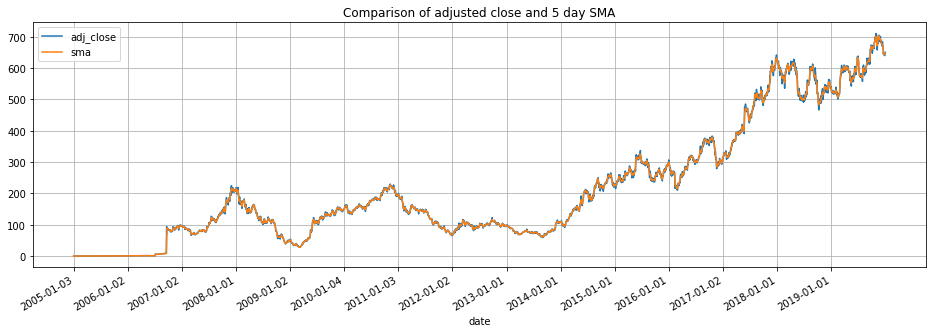

In [321]:
data[['adj_close', 'sma']].plot(figsize=(16,5), grid=True, xticks = data.groupby('year')['day_of_year'].idxmin())
plt.title('Comparison of adjusted close and 5 day SMA');

### Derive important yearly metrics

In [303]:
group_by_col = 'year'
agg_value_col = 'adj_close'
agg_value_col_sma = 'sma'
#Add yearly record count
year_agg_data = pd.concat([data.groupby(group_by_col)[agg_value_col].count().rename('record_cnt')
                      , data.groupby(group_by_col)[agg_value_col].min().rename('min_' + agg_value_col)
                      , data.groupby(group_by_col)[agg_value_col].idxmin().rename('date_min_' + agg_value_col)
                      , data.groupby(group_by_col)[agg_value_col].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col)
                      #, data.groupby(group_by_col)[agg_value_col].max().rename('max_' + agg_value_col)
                      #, data.groupby(group_by_col)[agg_value_col].idxmax().rename('date_max_' + agg_value_col)
                      #, data.groupby(group_by_col)[agg_value_col].mean().rename('mean_' + agg_value_col)
                      #, data.groupby(group_by_col)[agg_value_col].median().rename('median_' + agg_value_col)
                      , data.groupby(group_by_col)[agg_value_col_sma].min().rename('min_' + agg_value_col_sma)
                      , data.groupby(group_by_col)[agg_value_col_sma].idxmin().rename('date_min_' + agg_value_col_sma)
                      , data.groupby(group_by_col)[agg_value_col_sma].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col_sma)
                      #, data.groupby(group_by_col)[agg_value_col_sma].max().rename('max_' + agg_value_col_sma)
                      #, data.groupby(group_by_col)[agg_value_col_sma].idxmax().rename('date_max_' + agg_value_col_sma)
                      #, data.groupby(group_by_col)[agg_value_col_sma].mean().rename('mean_' + agg_value_col_sma)
                      #, data.groupby(group_by_col)[agg_value_col_sma].median().rename('median_' + agg_value_col_sma)
                          ], axis=1)
year_agg_data['min_date_diff'] = abs(year_agg_data.doy_min_adj_close - year_agg_data.doy_min_sma)
year_agg_data

,record_cnt,min_adj_close,date_min_adj_close,doy_min_adj_close,min_sma,date_min_sma,doy_min_sma,min_date_diff
year,,,,,,,,
2005,248,0.318705,2005-01-14,14,0.322459,2005-01-18,18,4
2006,247,1.007894,2006-01-02,2,1.021567,2006-01-02,2,0
2007,248,66.763321,2007-03-07,66,69.214301,2007-03-08,67,1
2008,245,39.967278,2008-12-01,336,40.305404,2008-12-03,338,2
2009,238,28.219854,2009-03-04,63,28.436597,2009-03-06,65,2
2010,250,134.180527,2010-02-19,50,135.068051,2010-02-23,54,4
2011,246,65.353828,2011-12-29,363,67.359880,2011-12-29,363,0
2012,245,67.602768,2012-01-02,2,68.250456,2012-01-02,2,0
2013,248,59.798470,2013-09-03,246,61.141842,2013-09-05,248,2


As indicated in the above dataframe, in most year's the date of min. adjusted close price is within a week of the date of min. adjusted simple moving avg. of close price. However, for some years, the value is very far. Hence, it is proven that it makes sense to use SMA

In [14]:
year_agg_data = year_agg_data[year_agg_data.min_adj_close > 0]

In [15]:
year_agg_data

,record_cnt,min_adj_close,date_min_adj_close,doy_min_adj_close,min_sma,date_min_sma,doy_min_sma,min_date_diff
year,,,,,,,,
2005,248,0.318705,2005-01-14,14,0.322459,2005-01-18,18,-4
2006,247,1.007894,2006-01-02,2,1.021567,2006-01-02,2,0
2007,248,66.763321,2007-03-07,66,69.214301,2007-03-08,67,-1
2008,245,39.967278,2008-12-01,336,40.305404,2008-12-03,338,-2
2009,238,28.219854,2009-03-04,63,28.436597,2009-03-06,65,-2
2010,250,134.180527,2010-02-19,50,135.068051,2010-02-23,54,-4
2011,246,65.353828,2011-12-29,363,67.359880,2011-12-29,363,0
2012,245,67.602768,2012-01-02,2,68.250456,2012-01-02,2,0
2013,248,59.798470,2013-09-03,246,61.141842,2013-09-05,248,-2


In [16]:
#Remove years when Adjusted close < 0
data = data[data.year >= year_agg_data.index[0]] 
data.head() 

,High,Low,Open,Close,Volume,adj_close,sma,year,day_of_year,week_of_year,month,day,day_of_week
date,,,,,,,,,,,,,
2005-01-03,2.049,2.000,2.026,2.039,918990.0,0.341662,0.336702,2005,3,1,1,3,0
2005-01-04,2.062,2.002,2.060,2.018,450800.0,0.338143,0.337473,2005,4,1,1,4,1
2005-01-05,2.038,1.876,2.038,2.013,767470.0,0.337305,0.336936,2005,5,1,1,5,2
2005-01-06,2.020,1.930,1.975,2.000,474890.0,0.335127,0.335864,2005,6,1,1,6,3
2005-01-07,2.028,1.961,2.020,1.984,391350.0,0.332446,0.333786,2005,7,1,1,7,4


In [17]:
years_of_data = len(data.index.year.unique())  #len(year_agg_data)
years_of_data

15

In [18]:
frequency = int(round(len(data) / years_of_data, 0))
fix_frq = year_agg_data.record_cnt.min()
frequency, fix_frq

(246, 238)

In [19]:
#Remove data when record of year > fixed freq
fix_frq_data = data.groupby(group_by_col).head(fix_frq)
len(fix_frq_data), len(year_agg_data), len(fix_frq_data)/len(year_agg_data)

(3570, 15, 238.0)

In [20]:
fix_frq_data.groupby(group_by_col)[agg_value_col].count()

year
2005    238
2006    238
2007    238
2008    238
2009    238
2010    238
2011    238
2012    238
2013    238
2014    238
2015    238
2016    238
2017    238
2018    238
2019    238
Name: adj_close, dtype: int64

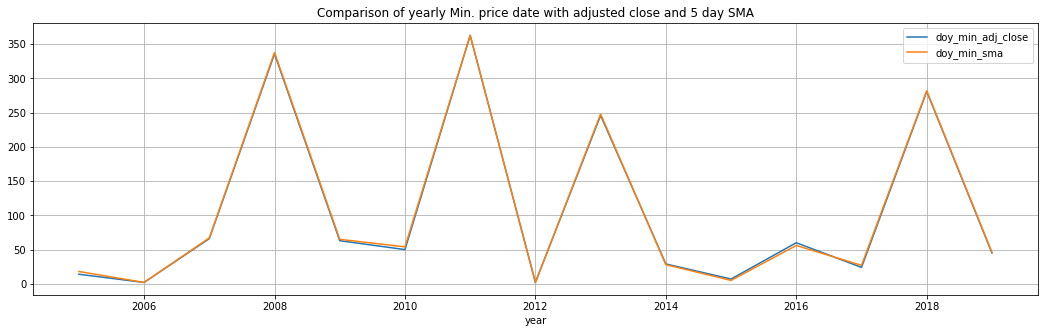

In [332]:
year_agg_data[['doy_min_adj_close', 'doy_min_sma']].plot(figsize=(18,5), grid=True)
plt.title('Comparison of yearly Min. price date with adjusted close and 5 day SMA');

### Auto-correlation plots

Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

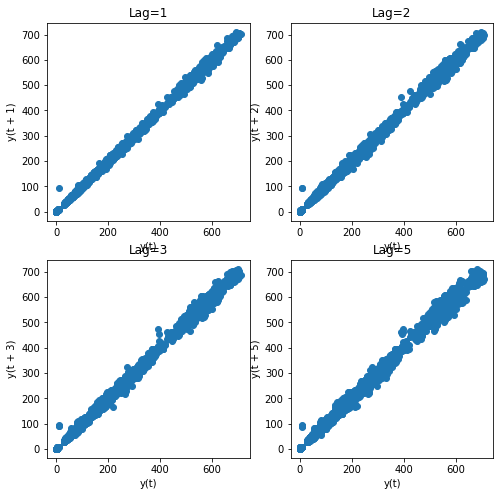

In [22]:
#from pandas.plotting import lag_plot

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plt.title(stock_ticker + 'Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0, 1),
    (0, 1, 2),
    (1, 0, 3),
    (1, 1, 5)
]

for x, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col, lag = ax_coords
    axis = axes[ax_row][ax_col]
    pd.plotting.lag_plot(data[agg_value_col], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

## Build Train-Test Datasets

Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [23]:
max_possible_cross_val = years_of_data - min_train_data_years

In [24]:
test_data_years = min(max_possible_cross_val, max_cross_val)
print('Test data period: ' + str(test_data_years) + ' years')

Test data period: 5 years


In [25]:
train_data_years = len(year_agg_data) - test_data_years
print('Train data period: ' + str(train_data_years) + ' years')

Train data period: 10 years


In [26]:
train_data = data[data.year < now.year - test_data_years] 
test_data = data[data.year >= now.year - test_data_years]  

In [27]:
train_data.index.year.drop_duplicates(), test_data.index.year.drop_duplicates()

(Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype='int64', name='date'),
 Int64Index([2015, 2016, 2017, 2018, 2019], dtype='int64', name='date'))

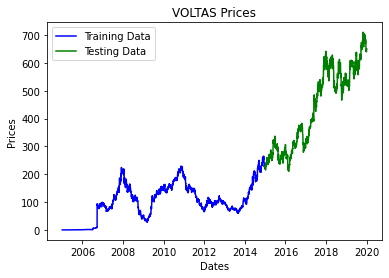

In [333]:
plt.figure(figsize=(6,4))
plt.title(stock_ticker + ' Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data[agg_value_col], 'blue', label='Training Data')
plt.plot(test_data[agg_value_col], 'green', label='Testing Data')
plt.legend();

### ADF test

In [29]:
train_series = train_data[agg_value_col]

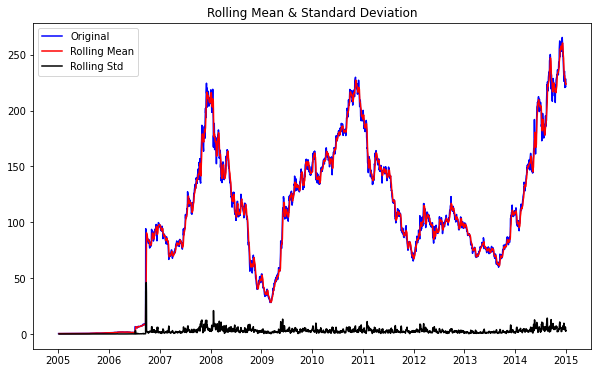

In [30]:
eda_window = rolling_window #7

#Determing rolling statistics
rolmean = train_series.rolling(eda_window).mean()
rolstd = train_series.rolling(eda_window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [31]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.166804
p-value                           0.687710
#Lags Used                        4.000000
Number of Observations Used    2454.000000
Critical Value (1%)              -3.433018
Critical Value (5%)              -2.862718
Critical Value (10%)             -2.567397
dtype: float64

In [32]:
dfoutput['p-value']

0.6877104869760992

If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. From the above statistics, we can observe that the p-value is 0.66 which proves that our series is not stationary. To get stationary data, there are many techniques. We can use log, differencing and so on. 

#### Apply a first order differencing on the training data

In [33]:
train_diff = train_series.diff(periods=1)
train_diff = train_diff.dropna(inplace = False)

In [34]:
eda_window = rolling_window #7
#Determing rolling statistics
rolmean = train_diff.rolling(eda_window).mean()
rolstd = train_diff.rolling(eda_window).std()

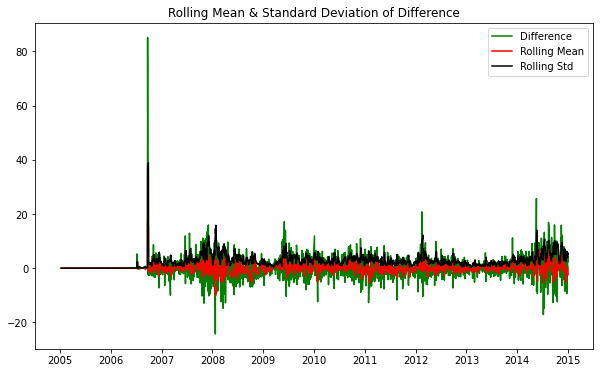

In [35]:
#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
#orig = plt.plot(train_series, color='blue',label='Original')
diff = plt.plot(train_diff, color='green',label='Difference')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Difference');

In [36]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -26.749173
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2454.000000
Critical Value (1%)              -3.433018
Critical Value (5%)              -2.862718
Critical Value (10%)             -2.567397
dtype: float64

In [37]:
dfoutput['p-value']

0.0

<font color="orange">After differencing, the p-value is extremely small. Hence, it is evident that series becomes stationary after applying first order differencing</font>

Also Test Statistic is less than critical values, indicating stationarity.

##### Plot ACF and PACF on the original train series

In [38]:
#pmdarima.utils.plot_acf(series, ax=None, lags=None, alpha=None, use_vlines=True, unbiased=False, fft=True, 
    #title='Autocorrelation', zero=True, vlines_kwargs=None, show=True, **kwargs)
#pmdarima.utils.plot_pacf(series, ax=None, lags=None, alpha=None, method='yw' #{‘yw’, ‘ywm’, ‘ols’, ‘ld’, ‘ldb’, ‘ldunbiased’, ‘ldbiased’}:
    #, use_vlines=True, title='Partial Autocorrelation', zero=True, vlines_kwargs=None, show=True, **kwargs)

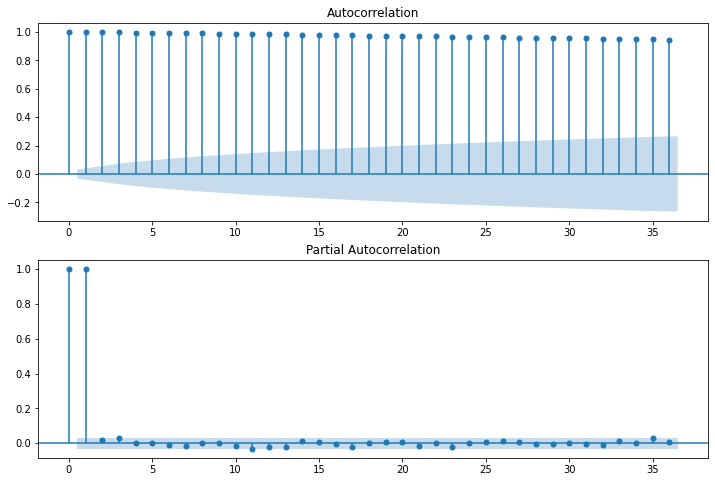

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data[agg_value_col], ax=ax[0]); 
plot_pacf(data[agg_value_col], ax=ax[1]); 

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


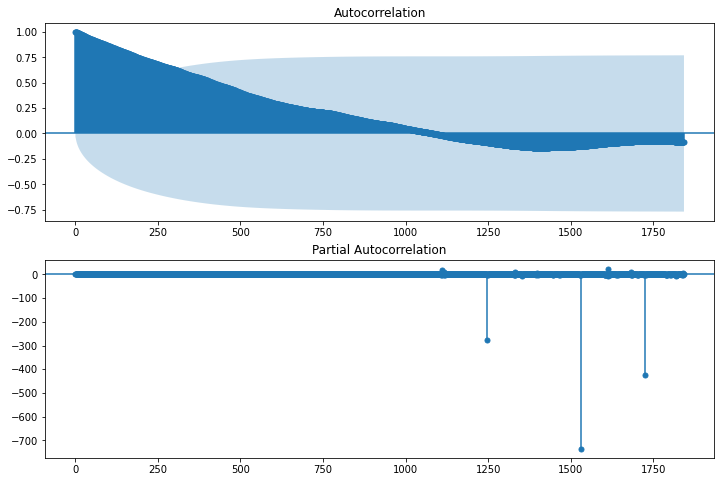

In [40]:
#Check on entire data, i.e. test_data
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data[agg_value_col], ax=ax[0], lags=len(data) /2 - 1); 
#For PACF the lag should be limited to half of total data size
plot_pacf(data[agg_value_col], ax=ax[1], lags=len(data) /2 - 1); 

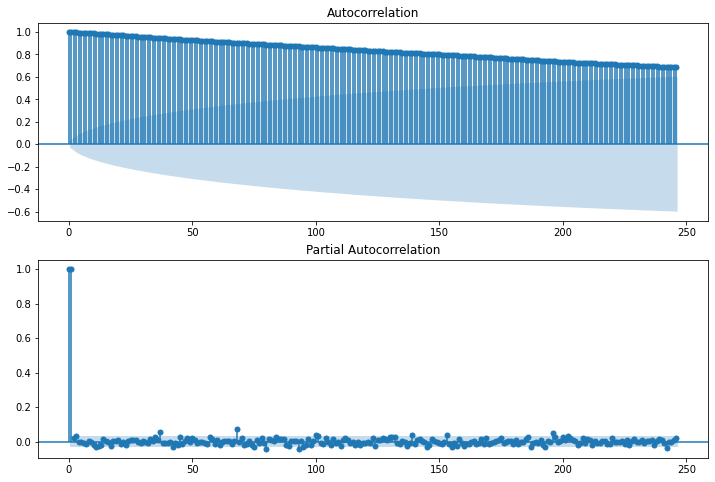

In [41]:
#Check on entire data, i.e. test_data
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data[agg_value_col], ax=ax[0], lags=frequency); 
plot_pacf(data[agg_value_col], ax=ax[1], lags=frequency); 

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


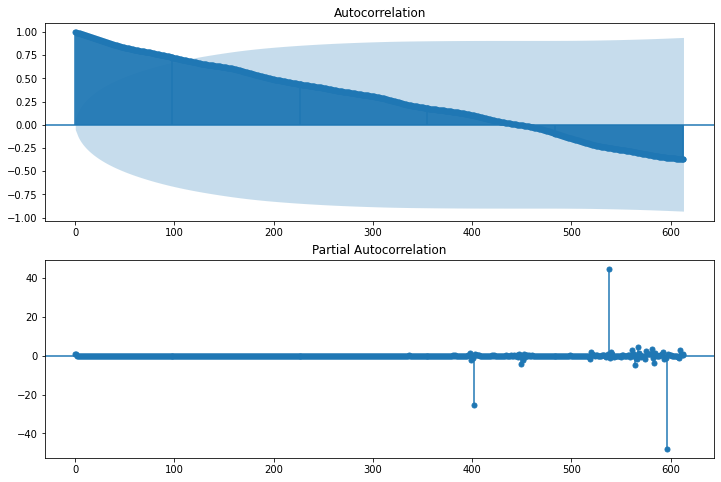

In [42]:
#Check on relatively latest data, i.e. test_data
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(test_data[agg_value_col], ax=ax[0], lags=len(test_data)/2 - 1 ); 
#For PACF the lag should be limited to half of total data size
plot_pacf(test_data[agg_value_col], ax=ax[1], lags=len(test_data)/2 - 1 ); 

As per the above plots, there is a definite change in ACF after @245 days, indicating a yearly seasonality with m = 245
<br>There is not much information to derive p,q and P,Q values 

##### Plot ACF and PACF on the differenced train series

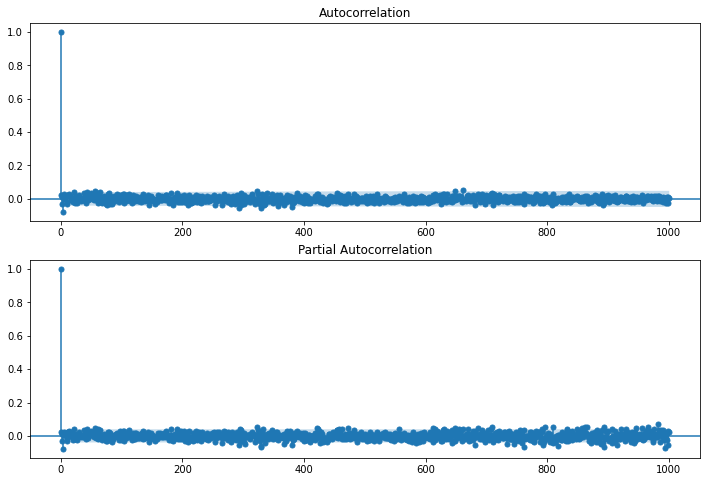

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0], lags=1000);  
plot_pacf(train_diff, ax=ax[1], lags=1000); 

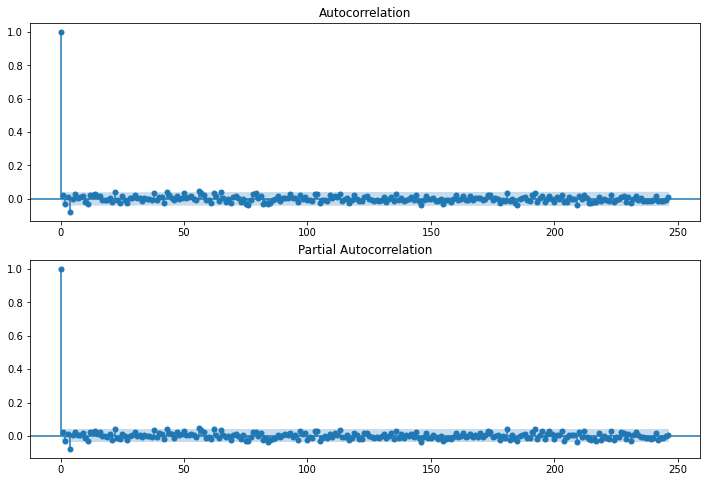

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0], lags=frequency);  
plot_pacf(train_diff, ax=ax[1], lags=frequency); 

###### Set last 1 year data for testing with rest of the data for training

In [263]:
train_1year = data[data.year < now.year - 1] 
test_1year = data[data.year == now.year - 1]  
y_train_1year = train_1year[agg_value_col].values
y_test_1year = test_1year[agg_value_col].values
print(len(y_train_1year), len(y_test_1year))

3445 242


### Validate seasonality using Seasonal decompose

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

<br> For daily data with yearly sesonality, m = 365.25
<br> However in our case we have @245 records per year, hence, m = 245

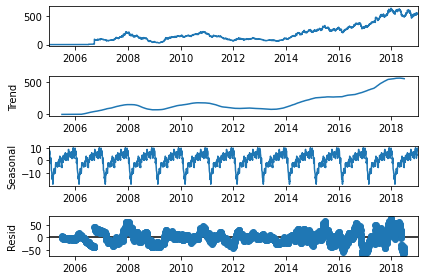

In [264]:
sm_sd_add = seasonal_decompose(train_1year[[agg_value_col]], model='additive', period=frequency)
sm_sd_add.plot()
plt.show()

<font color="orange">From the graph plotted, we can see that seasonality plot indicates clear seasonality.
There is residual, which means decomposition was able to separate noise from the linear trend.</font>

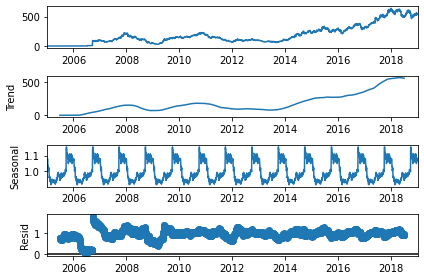

In [265]:
sm_sd_mul = seasonal_decompose(train_1year[[agg_value_col]], model='multiplicative', period=frequency)
sm_sd_mul.plot()
plt.show()

<font color="orange">From the graph plotted, we can see that seasonality plot indicates clear seasonality.
There is residual, which means decomposition was able to separate noise from the linear trend.</font>

## Holt Winters

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

In [50]:
model_aa = HWES(y_train_1year, seasonal_periods=frequency, trend='add', seasonal='add')
#trend, seasonal: {“add”, “mul”, “additive”, “multiplicative”, None}, optional
#initialization_method: None, ‘estimated’(Default), ‘heuristic’, ‘legacy-heuristic’, ‘known’  
#use_boxcox{True, False, ‘log’, float}, optional
fitted_aa = model_aa.fit()
print(fitted_aa.summary())

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 3445
Model:             ExponentialSmoothing   SSE                         101042.461
Optimized:                         True   AIC                          12139.335
Trend:                         Additive   BIC                          13675.505
Seasonal:                      Additive   AICC                         12179.283
Seasonal Periods:                   246   Date:                 Wed, 02 Sep 2020
Box-Cox:                          False   Time:                         18:58:29
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9592200                alpha                 True
smoothing_trend       

In [51]:
forecast_aa = fitted_aa.forecast(steps=len(y_test_1year))

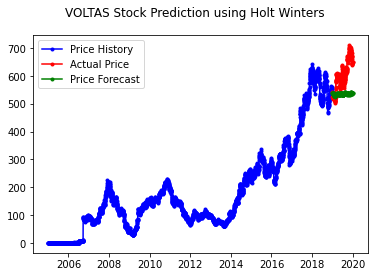

In [52]:
fig = plt.figure()
fig.suptitle(stock_ticker + ' Stock Prediction using Holt Winters')
past, = plt.plot(train_1year.index, y_train_1year, 'b.-', label='Price History')
future, = plt.plot(test_1year.index, y_test_1year, 'r.-', label='Actual Price')
predicted_future, = plt.plot(test_1year.index, forecast_aa, 'g.-', label='Price Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

In [53]:
model_an = HWES(y_train_1year, seasonal_periods=frequency, trend='add', seasonal=None)
fitted_an = model_an.fit()
print(fitted_an.summary())
forecast_an = fitted_an.forecast(steps=len(y_test_1year))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 3445
Model:             ExponentialSmoothing   SSE                         108410.351
Optimized:                         True   AIC                          11889.804
Trend:                         Additive   BIC                          11914.383
Seasonal:                          None   AICC                         11889.828
Seasonal Periods:                  None   Date:                 Wed, 02 Sep 2020
Box-Cox:                          False   Time:                         18:58:30
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9242983                alpha                 True
smoothing_trend            0.00025

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [54]:
model_mn = HWES(y_train_1year, seasonal_periods=frequency, trend='mul', seasonal=None)
fitted_mn = model_mn.fit()
print(fitted_mn.summary())
forecast_mn = fitted_mn.forecast(steps=len(y_test_1year))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 3445
Model:             ExponentialSmoothing   SSE                         120040.978
Optimized:                         True   AIC                          12240.882
Trend:                   Multiplicative   BIC                          12265.461
Seasonal:                          None   AICC                         12240.907
Seasonal Periods:                  None   Date:                 Wed, 02 Sep 2020
Box-Cox:                          False   Time:                         18:58:30
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9242857                alpha                 True
smoothing_trend            0.02254

In [55]:
model_ma = HWES(y_train_1year, seasonal_periods=frequency, trend='mul', seasonal='add')
fitted_ma = model_ma.fit()
print(fitted_ma.summary())
forecast_ma = fitted_ma.forecast(steps=len(y_test_1year))

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 3445
Model:             ExponentialSmoothing   SSE                         101764.907
Optimized:                         True   AIC                          12163.879
Trend:                   Multiplicative   BIC                          13700.049
Seasonal:                      Additive   AICC                         12203.827
Seasonal Periods:                   246   Date:                 Wed, 02 Sep 2020
Box-Cox:                          False   Time:                         18:58:32
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9485726                alpha                 True
smoothing_trend       

In [56]:
model_am = HWES(y_train_1year, seasonal_periods=frequency, trend='add', seasonal='mul')
fitted_am = model_am.fit()
print(fitted_am.summary())
forecast_am = fitted_am.forecast(steps=len(y_test_1year))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 3445
Model:             ExponentialSmoothing   SSE                        2250096.848
Optimized:                         True   AIC                          22829.817
Trend:                         Additive   BIC                          24365.987
Seasonal:                Multiplicative   AICC                         22869.764
Seasonal Periods:                   246   Date:                 Wed, 02 Sep 2020
Box-Cox:                          False   Time:                         18:58:33
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9242857                alpha                 True
smoothing_trend       

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [57]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from numpy import *

In [58]:
hwes_results = pd.DataFrame(index = ['mae', 'rmse', 'smape'])
hwes_results['add_None'] = [mean_absolute_error(y_test_1year, forecast_an), 
                            sqrt(mean_squared_error(y_test_1year, forecast_an)),
                            smape(y_test_1year, forecast_an)]
hwes_results['mul_None'] = [mean_absolute_error(y_test_1year, forecast_mn), 
                           sqrt( mean_squared_error(y_test_1year, forecast_mn)),
                            smape(y_test_1year, forecast_mn)]
hwes_results['add_add'] = [mean_absolute_error(y_test_1year, forecast_aa), 
                            sqrt(mean_squared_error(y_test_1year, forecast_aa)),
                            smape(y_test_1year, forecast_aa)]
hwes_results['mul_add'] = [mean_absolute_error(y_test_1year, forecast_ma), 
                            sqrt(mean_squared_error(y_test_1year, forecast_ma)),
                            smape(y_test_1year, forecast_ma)]
hwes_results['add_mul'] = [mean_absolute_error(y_test_1year, forecast_am), 
                            sqrt(mean_squared_error(y_test_1year, forecast_am)),
                            smape(y_test_1year, forecast_am)]
hwes_results

,add_None,mul_None,add_add,mul_add,add_mul
mae,51.659199,55.014437,71.767178,71.703996,297.667854
rmse,63.032040,66.786826,86.368641,86.191683,307.778394
smape,8.611303,9.203187,12.233068,12.221682,69.166650


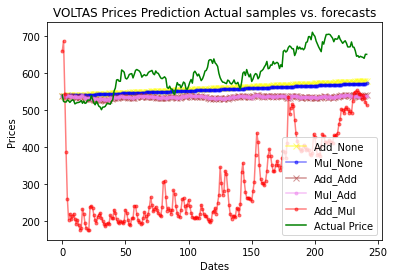

In [59]:
plt.figsize = (12, 20)
x = np.arange(len(y_test_1year))
an, = plt.plot(x, forecast_an, color='yellow', alpha=0.5, marker='x', label='Add_None')
mn, = plt.plot(x, forecast_mn, color='blue', alpha=0.5, marker='.', label='Mul_None')
aa, = plt.plot(x, forecast_aa, color='brown', alpha=0.5, marker='x', label='Add_Add')
ma, = plt.plot(x, forecast_ma, color='violet', alpha=0.5, marker='.', label='Mul_Add')
am, = plt.plot(x, forecast_am, color='red', alpha=0.5, marker='.', label='Add_Mul')
future, = plt.plot(x, y_test_1year, color='green', label='Actual Price')
plt.title(stock_ticker + ' Prices Prediction Actual samples vs. forecasts')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend(handles=[an, mn, aa, ma, am, future])
plt.show()

<font color="orange">Holt Winters Exponential Smoothing: Best output achieved with seasonal_periods=frequency, trend='mul', seasonal='add'</font>

## Auto Arima

In [60]:
#!pip install pmdarima

In [61]:
import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.7.0


In [62]:
y_train = train_data[agg_value_col].values
y_test = test_data[agg_value_col].values

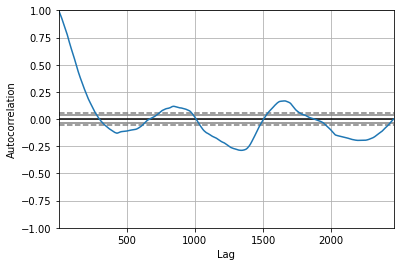

In [63]:
pm.utils.autocorr_plot(y_train, show=True)

<font color="orange">Above graph indicates a significant chage in trend after every @250 intervals indicating a yearly seasonality</font>

###### Seasonal Decomposition

Text(0.5, 1.0, 'Stock Price Seasonal Decomposition - additive')

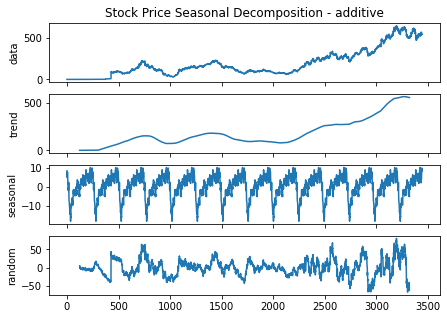

In [266]:
figure_kwargs = {'figsize': (7, 5)}

#Ref: examples/arima/example_seasonal_decomposition.ipynb
pm_sd_add = pm.arima.decompose(train_1year[agg_value_col].values, type_='additive', m=frequency, filter_=None)
axes = pm.utils.decomposed_plot(pm_sd_add, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Stock Price Seasonal Decomposition - additive")

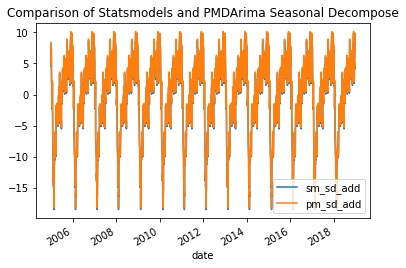

Statsmodels Seasonal Min-Max: (-18.509652353070987, 9.916627120720188)
PMDArima Seasonal Min-Max: (-18.26379680100496, 10.148688355242903)


In [267]:
sd_add = pd.DataFrame()
sd_add.insert(len(sd_add.columns), 'sm_sd_add', sm_sd_add.seasonal)
#sd_add['pm_sd_add'] = pm_sd_add.seasonal
sd_add.insert(len(sd_add.columns), 'pm_sd_add', pm_sd_add.seasonal)
sd_add[['sm_sd_add', 'pm_sd_add']].plot()
plt.title('Comparison of Statsmodels and PMDArima Seasonal Decompose');
plt.show()
print(f"Statsmodels Seasonal Min-Max: {np.nanmin(sd_add.sm_sd_add), np.nanmax(sd_add.sm_sd_add)}")
print(f"PMDArima Seasonal Min-Max: {np.nanmin(sd_add.pm_sd_add), np.nanmax(sd_add.pm_sd_add)}")

Text(0.5, 1.0, 'Stock Price Seasonal Decomposition - multiplicative')

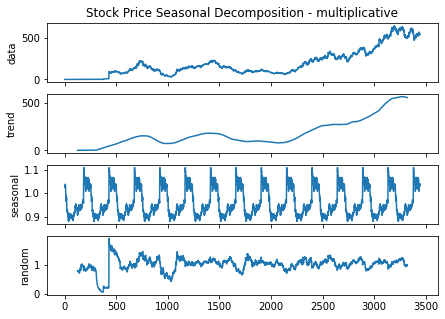

In [268]:
pm_sd_mul = pm.arima.decompose(train_1year[agg_value_col].values, type_='multiplicative', m=frequency, filter_=None)
axes = pm.utils.decomposed_plot(pm_sd_mul, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Stock Price Seasonal Decomposition - multiplicative")

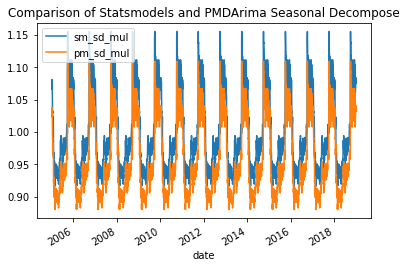

Statsmodels Seasonal Min-Max: (0.9163714321990393, 1.1551424895949078)
PMDArima Seasonal Min-Max: (0.8799235923066208, 1.1091049340427643)


In [269]:
sd_mul = pd.DataFrame()
sd_mul.insert(len(sd_mul.columns), 'sm_sd_mul', sm_sd_mul.seasonal)
#sd_add['pm_sd_mul'] = pm_sd_mul.seasonal
sd_mul.insert(len(sd_mul.columns), 'pm_sd_mul', pm_sd_mul.seasonal)
sd_mul[['sm_sd_mul', 'pm_sd_mul']].plot()
plt.title('Comparison of Statsmodels and PMDArima Seasonal Decompose');
plt.show()
print(f"Statsmodels Seasonal Min-Max: {np.nanmin(sd_mul.sm_sd_mul), np.nanmax(sd_mul.sm_sd_mul)}")
print(f"PMDArima Seasonal Min-Max: {np.nanmin(sd_mul.pm_sd_mul), np.nanmax(sd_mul.pm_sd_mul)}")

<font color="orange">As per above plots, there is clearly a yearly seasonality observed in the stock</font>

###### ACF/PACF
<br>Just wrapper methods for the statsmodels plot_acf and plot_pacf methods. Separate analysis not required.

###### Check for stationarity

In [68]:
# Test whether we should difference at the alpha=0.05 significance level
adf_test = pm.arima.ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(train_data[agg_value_col].values)  # (0.01, False)
print ("p_value: ", p_val)
print ("Differencing required: ", should_diff)

p_value:  0.7133897734438523
Differencing required:  True


###### Getting value of differencing term d

In [69]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
pp_diffs = ndiffs(y_train, alpha=0.05, test='pp', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs, pp_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


###### Conduct a CH test for seasonality.

In [70]:
frequency = int(round(len(train_data) / train_data_years, 0))
# Test whether we should difference for seasonality
ch_test = pm.arima.CHTest(m = frequency)
est_sfreq = ch_test.estimate_seasonal_differencing_term(train_data[agg_value_col].values)
print ("Seasonal Differencing critical values: ", est_sfreq)

Seasonal Differencing critical values:  0


###### Perform an OCSB test of seasonality.

In [71]:
# Test whether we should difference at the alpha=0.05 significance level
# optional lag_method='aic' Default, One of (“fixed”, “aic”, “bic”, “aicc”)
# optional max_lag=3 Default, int value
ocsb_test = pm.arima.OCSBTest(m = frequency, lag_method='fixed', max_lag=3)
sfreq = ocsb_test.estimate_seasonal_differencing_term(train_data[agg_value_col].values)
print ("Seasonal Differencing critical values: ", sfreq)

Seasonal Differencing critical values:  0


###### Get the seasonal differencing term, D. 

In [72]:
##directly estimates the number of seasonal differences.
ocsb_sdiffs = pm.arima.nsdiffs(y_train, m=frequency, test='ocsb', max_D=6)
ch_sdiffs = pm.arima.nsdiffs(y_train, m=frequency, test='ch', max_D=6)
n_sdiffs = max(ocsb_sdiffs, ch_sdiffs)

print(f"Estimated seasonal differencing term: {n_sdiffs}")

Estimated seasonal differencing term: 0


All the above tests with various combinations indicates that there is no sesonality observed in data

###### Auto Arima forecasting

In [73]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, max_p=6, trace=2)
print(auto.order)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13654.388, Time=1.22 sec
First viable model found (13654.388)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13654.413, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13655.312, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13655.247, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13653.807, Time=0.06 sec
New best model found (13653.807 < 13654.388)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13652.181, Time=0.36 sec
New best model found (13652.181 < 13653.807)
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13653.280, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13653.316, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13654.931, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13655.360, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13651.521, Time=0.13 sec
New best model found (13651.521 < 13652.181)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13654.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2459
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6822.761
Date:                Wed, 02 Sep 2020   AIC                          13651.521
Time:                        18:59:06   BIC                          13668.942
Sample:                             0   HQIC                         13657.851
                               - 2459                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7108      0.141     -5.032      0.000      -0.988      -0.434
ma.L1          0.7464      0.134      5.558      0.000       0.483       1.010
sigma2        15.0833      0.061    245.751      0.000      14.963      15.204
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):            959449.37
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             4.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test, forecasts))}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean absolute error: 6.3896394245223345
Root Mean squared error: 8.670632671208459
SMAPE: 1.5292941726249953


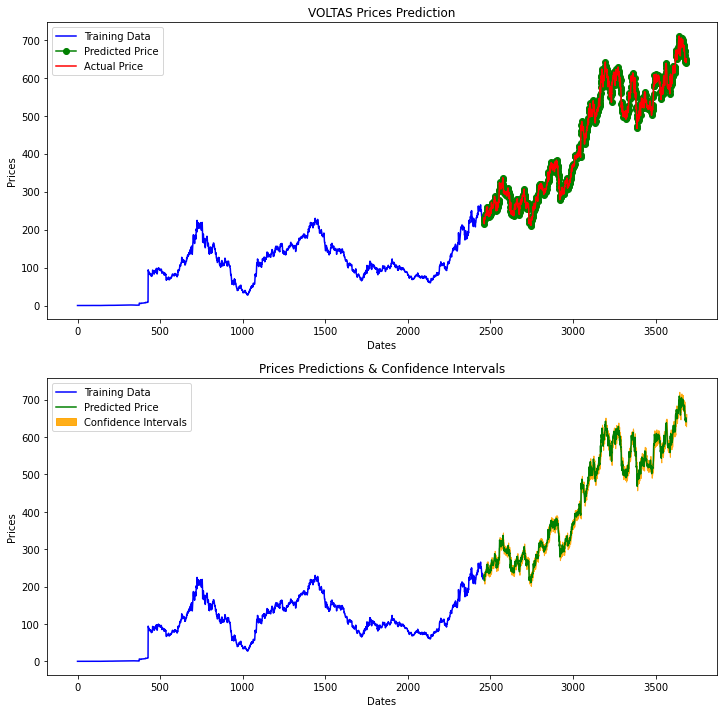

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
test_range = np.arange(len(y_train), len(data))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_range, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_range, y_test, color='red', label='Actual Price')
axes[0].set_title(stock_ticker + ' Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

#axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), data.index[0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_range, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_range,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), data.index[0:7982:1300].tolist())
axes[1].legend()

plt.show()

Revamping the model on the daily basis, will obviosuly improve the accuracy. <br>However, this approach can't be used for our problem statement

#### Forecast on yearly basis

In [76]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, max_p=6, trace=2)
print(auto.order)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13654.388, Time=1.22 sec
First viable model found (13654.388)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13654.413, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13655.312, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13655.247, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13653.807, Time=0.05 sec
New best model found (13653.807 < 13654.388)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13652.181, Time=0.36 sec
New best model found (13652.181 < 13653.807)
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13653.280, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13653.316, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13654.931, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13655.360, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13651.521, Time=0.11 sec
New best model found (13651.521 < 13652.181)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13654.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2459
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6822.761
Date:                Wed, 02 Sep 2020   AIC                          13651.521
Time:                        19:06:13   BIC                          13668.942
Sample:                             0   HQIC                         13657.851
                               - 2459                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7108      0.141     -5.032      0.000      -0.988      -0.434
ma.L1          0.7464      0.134      5.558      0.000       0.483       1.010
sigma2        15.0833      0.061    245.751      0.000      14.963      15.204
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):            959449.37
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             4.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
model = auto  # seeded from the model we've already fit

def forecast_one_step(obsvns):
    fc, conf_int = model.predict(n_periods=obsvns, return_conf_int=True)
    return (
        fc.tolist(),
        np.asarray(conf_int).tolist())

forecasts = []
confidence_intervals = []
last_record = 0

for year in test_data.year.unique() :
    size = len(data[data.year == year])
    fc, conf = forecast_one_step(size)
    forecasts.extend(fc)
    confidence_intervals.extend(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(y_test[last_record : last_record + size])
    last_record = last_record + size - 1
    
print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test, forecasts))}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean absolute error: 75.56404198220395
Root Mean squared error: 98.91593992045024
SMAPE: 17.98840061435981


In [78]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3687
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -11781.728
Date:                Wed, 02 Sep 2020   AIC                          23569.457
Time:                        19:06:18   BIC                          23588.094
Sample:                             0   HQIC                         23576.091
                               - 3687                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9171      0.062    -14.727      0.000      -1.039      -0.795
ma.L1          0.9049      0.067     13.590      0.000       0.774       1.035
sigma2        34.9812      0.265    131.811      0.000      34.461      35.501
===================================================================================
Ljung-Box (L1) (Q):                   4.41   Jarque-Bera (JB):             44138.64
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               4.36   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

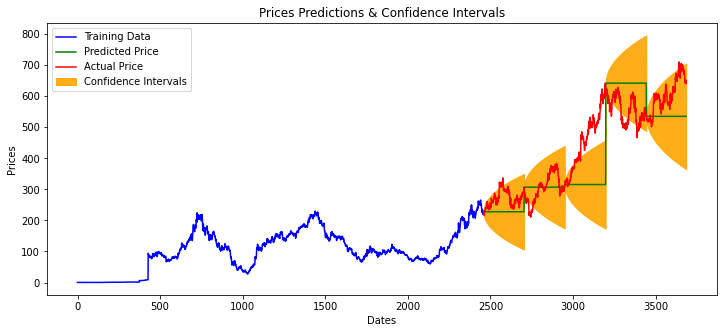

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
test_range = np.arange(len(y_train), len(data))

# ------------------ Predicted with confidence intervals ----------------
axes.plot(y_train, color='blue', label='Training Data')
axes.plot(test_range, forecasts, color='green', label='Predicted Price')
axes.plot(test_range, y_test, color='red', label='Actual Price')
axes.set_title('Prices Predictions & Confidence Intervals')
axes.set_xlabel('Dates')
axes.set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes.fill_between(test_range,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), data.index[0:7982:1300].tolist())
axes.legend()

plt.show()

In [80]:
#get last year forecasts
fc_1year = forecasts[-len(test_1year):]
y_1year = data[data.year == now.year - 1][agg_value_col].values

#last year analysis
print(f"Mean absolute error: {mean_absolute_error(y_1year, fc_1year)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_1year, fc_1year))}")
print(f"SMAPE: {smape(y_1year, fc_1year)}")

Mean absolute error: 72.97703214632223
Root Mean squared error: 87.35978483517304
SMAPE: 12.457669355784283


On analysing the predicted output for last 1 year, we see that the accuracy improves, however it is still below the mark

#### Forecast for 1 year

In [81]:
auto = pm.auto_arima(y_train_1year, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, max_p=6, trace=2)
print(auto.order)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21653.801, Time=4.02 sec
First viable model found (21653.801)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21670.313, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21658.923, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21657.989, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21670.977, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21658.518, Time=1.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21658.494, Time=1.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21662.433, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21662.471, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21656.896, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21660.471, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21660.421, Time=1.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21656.674, Time=5.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=21654.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3445
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -10820.901
Date:                Wed, 02 Sep 2020   AIC                          21653.801
Time:                        19:06:37   BIC                          21690.668
Sample:                             0   HQIC                         21666.969
                               - 3445                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0129      0.010      1.278      0.201      -0.007       0.033
ar.L1          1.5178      0.091     16.653      0.000       1.339       1.696
ar.L2         -0.6004      0.091     -6.594      0.000      -0.779      -0.422
ma.L1         -1.5839      0.086    -18.393      0.000      -1.753      -1.415
ma.L2          0.6676      0.086      7.775      0.000       0.499       0.836
sigma2        31.3756      0.234    134.083      0.000      30.917      31.834
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             62784.06
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.84   Skew:                             1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
fc_simple, conf = auto.predict(n_periods=len(y_test_1year), return_conf_int=True)
print(f"Mean absolute error: {mean_absolute_error(y_test_1year, fc_simple)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test_1year, fc_simple))}")
print(f"SMAPE: {smape(y_test_1year, fc_simple)}")

Mean absolute error: 54.38183695010859
Root Mean squared error: 66.05526665450705
SMAPE: 9.091115974043765


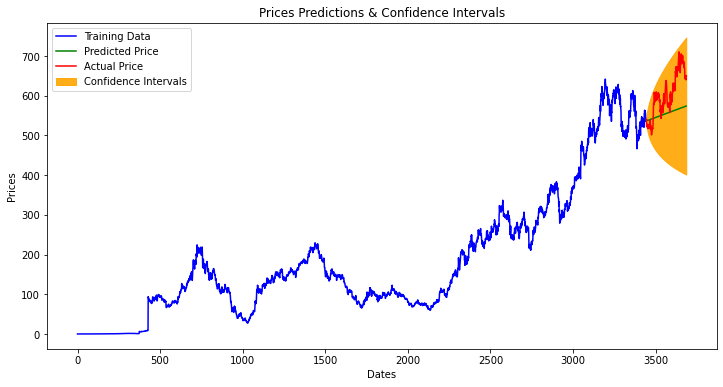

In [83]:
fig, axes = plt.subplots(figsize=(12, 6))
test_range = np.arange(len(y_train_1year), len(data))

# ------------------ Predicted with confidence intervals ----------------
axes.plot(y_train_1year, color='blue', label='Training Data')
axes.plot(test_range, fc_simple, color='green',
             label='Predicted Price')
axes.plot(test_range, y_test_1year, color='red', label='Actual Price')
axes.set_title('Prices Predictions & Confidence Intervals')
axes.set_xlabel('Dates')
axes.set_ylabel('Prices')

conf_int = np.asarray(conf)
axes.fill_between(test_range,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), data.index[0:7982:1300].tolist())
axes.legend()

plt.show()

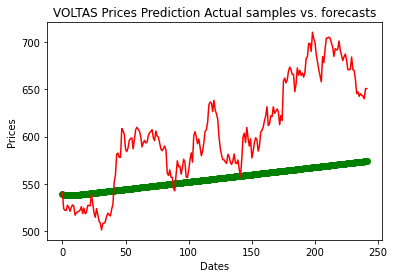

In [84]:
x = np.arange(len(y_test_1year))
plt.scatter(x, fc_simple, color='green', marker='o')
plt.plot(x, y_test_1year, color='red', label='Actual Price')
plt.title(stock_ticker + ' Prices Prediction Actual samples vs. forecasts')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

###### Training with parts of date as exogenous features

In [85]:
train_1year = data[data.year < now.year - 1] 
test_1year = data[data.year == now.year - 1]  

exogenous_features = ["year","month","week_of_year","day","day_of_year","day_of_week"
    #, "High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3", "Volume_mean_lag3", "Volume_std_lag3"
    #, "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7","Volume_mean_lag7", "Volume_std_lag7
    #, "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30", "Volume_mean_lag30", "Volume_std_lag30", 
                      ]

In [86]:
model = pm.auto_arima(train_1year.adj_close, exogenous=train_1year[exogenous_features], 
                      trace=True, error_action="ignore", suppress_warnings=True)
#Below line is not required
#model.fit(train_1year.adj_close, exogenous=train_1year[exogenous_features])

fc_date = model.predict(n_periods=len(test_1year), exogenous=test_1year[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21664.961, Time=3.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21674.825, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21662.964, Time=1.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21662.042, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21673.014, Time=2.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21661.188, Time=3.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21662.871, Time=4.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21662.893, Time=5.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21661.029, Time=1.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=21662.845, Time=1.73 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21664.832, Time=2.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21659.262, Time=1.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21660.261, Time=1.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21661.128, Time=3.63 sec
 ARIMA(0,1,3)(0,0,0

D:\ProgramFiles\Python\Anaconda3\envs\sbcapstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [87]:
print(f"Mean absolute error: {mean_absolute_error(test_1year.adj_close, fc_date)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(test_1year.adj_close, fc_date))}")
print(f"SMAPE: {smape(test_1year.adj_close, fc_date)}")

Mean absolute error: 47.256689382705225
Root Mean squared error: 58.28330171627471
SMAPE: 7.840413377902794


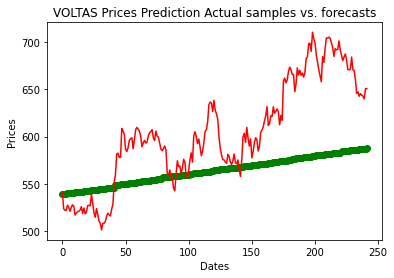

In [88]:
#One line plot code
#test_1year[["adj_close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

x = np.arange(len(test_1year))
plt.scatter(x, fc_date, color='green', marker='o')
plt.plot(x, y_test_1year, color='red', label='Actual Price')
plt.title(stock_ticker + ' Prices Prediction Actual samples vs. forecasts')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

As observed in above plot and metrics, there is a significant improvement on adding exogenous features even with same data and model paramters

###### Training with lag on stock price features + parts of date as exogenous features

###### Training with yearly seasonality using SARIMA

Seasonal Auto arima with long values of m are known to take very long times. This is a known issue even with R package.
When I tried using it, it resulted in memory errors even after taking a very long time.

In [89]:
#With large data the Seasonal Auto arima is not able to work with allocated RAM
#Taking only prev. 5 years data to reduce the size for training without memory errors
train_prev5yrs = data[(data.year >= now.year - 6) & (data.year < now.year - 1)]
y_train_prev5yrs = train_prev5yrs[agg_value_col].values
train_prev5yrs.year.unique()

array([2014, 2015, 2016, 2017, 2018], dtype=int64)

In [ ]:
sauto = pm.auto_arima(y_train_prev5yrs, d=n_diffs, #max_p=6, stepwise=True,
                     seasonal=True, D=n_sdiffs, m = frequency, #Seasonality 
                     suppress_warnings=True, trace=2)
print(sauto.order)
sauto.summary()

Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 1, 2)(1, 0, 1, 246); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
 ARIMA(2,1,2)(1,0,1)[246] intercept   : AIC=inf, Time=1089.70 sec
 ARIMA(0,1,0)(0,0,0)[246] intercept   : AIC=8611.780, Time=0.13 sec
First viable model found (8611.780)


MemoryError: Unable to allocate 578. MiB for an array with shape (248, 248, 1231) and data type float64

As observed above, with large value of m, the evaluation requires more memory. <br>
Need to be checked outside this Jupyter Notebook

In [91]:
#Another option is to use weekly data rather than daily data
weekly_col = 'week_of_year'
weekly_data = pd.concat([data.groupby([group_by_col, weekly_col])[agg_value_col].mean().rename('weekly_avg_' + agg_value_col),
                         data.groupby([group_by_col, weekly_col])[agg_value_col].median().rename('weekly_med_' + agg_value_col),
                         data.groupby([group_by_col, weekly_col])[agg_value_col_sma].mean().rename('weekly_avg_'+ agg_value_col_sma),
                         data.groupby([group_by_col, weekly_col])[agg_value_col_sma].median().rename('weekly_med_)'+ agg_value_col_sma)
                          ], axis=1)
#reset_index() will transfer index values into the DataFrame as columns
weekly_data.reset_index(inplace=True) 
weekly_data

,year,week_of_year,weekly_avg_adj_close,weekly_med_adj_close,weekly_avg_sma,weekly_med_)sma
0,2005,1,0.336936,0.337305,0.336152,0.336702
1,2005,2,0.328190,0.327754,0.328102,0.328190
2,2005,3,0.323397,0.323565,0.324746,0.324369
3,2005,4,0.338059,0.342081,0.339257,0.338428
4,2005,5,0.357681,0.357915,0.354557,0.354698
...,...,...,...,...,...,...
784,2019,49,683.792603,684.256409,683.577463,683.792603
785,2019,50,673.509277,670.933533,673.967192,673.509277
786,2019,51,653.130115,647.346985,654.229502,653.130115
787,2019,52,642.955338,643.226715,644.341904,644.450464


In [92]:
len(weekly_data), len(data)

(789, 3687)

In [93]:
train_weekly = weekly_data[weekly_data.year < now.year - test_data_years] 
test_weekly  = weekly_data[weekly_data.year >= now.year - test_data_years]  
train_weekly_1year = weekly_data[weekly_data.year < now.year - 1] 
test_weekly_1year = weekly_data[weekly_data.year == now.year - 1]  
y_train_weekly_1year = train_weekly_1year['weekly_avg_adj_close'].values
y_test_weekly_1year = test_weekly_1year['weekly_avg_adj_close'].values

In [94]:
swauto = pm.auto_arima(y_train_weekly_1year, d=n_diffs, #max_p=6, stepwise=True, 
                     seasonal=True, m = 53,#Seasonality for weekly data = 53 weeks 
                     D=n_sdiffs, #D=None, start_P=1, start_Q=1, 
                     suppress_warnings=True, trace=2)
print(swauto.order)
swauto.summary()

Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 1, 2)(1, 0, 1, 53); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
 ARIMA(2,1,2)(1,0,1)[53] intercept   : AIC=inf, Time=27.39 sec
 ARIMA(0,1,0)(0,0,0)[53] intercept   : AIC=5362.520, Time=0.03 sec
First viable model found (5362.520)
 ARIMA(1,1,0)(1,0,0)[53] intercept   : AIC=5321.533, Time=3.44 sec
New best model found (5321.533 < 5362.520)
 ARIMA(0,1,1)(0,0,1)[53] intercept   : AIC=5327.735, Time=3.59 sec
 ARIMA(0,1,0)(0,0,0)[53]             : AIC=5365.103, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[53] intercept   : AIC=5319.534, Time=0.08 sec
New best model found (5319.534 < 5321.533)
 ARIMA(1,1,0)(0,0,1)[53] intercept   : AIC=5321.533, Time=3.14 sec
Near non-invertible roots for order (1, 1, 0)(1, 0, 1, 53); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
 ARIMA(1,1,0)(1,0,1)[53] intercept   : AIC=inf, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  736
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2656.767
Date:                Wed, 02 Sep 2020   AIC                           5319.534
Time:                        19:09:31   BIC                           5333.333
Sample:                             0   HQIC                          5324.856
                                - 736                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5548      0.336      1.653      0.098      -0.103       1.213
ar.L1          0.2435      0.025      9.804      0.000       0.195       0.292
sigma2        80.7471      2.392     33.760      0.000      76.059      85.435
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               704.81
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
swforecast = swauto.predict(n_periods=len(test_weekly_1year))
print(f"Mean absolute error: {mean_absolute_error(y_test_weekly_1year, swforecast)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test_weekly_1year, swforecast))}")
print(f"SMAPE: {smape(y_test_weekly_1year, swforecast)}")

Mean absolute error: 52.4640126281006
Root Mean squared error: 63.463656170390756
SMAPE: 8.74610210834313


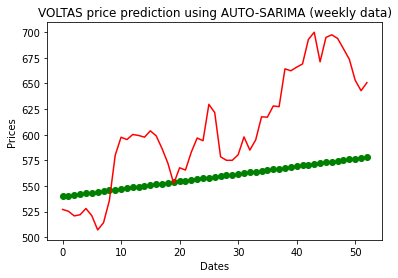

In [96]:
x = np.arange(len(test_weekly_1year))
plt.scatter(x, swforecast, color='green', marker='o')
plt.plot(x, y_test_weekly_1year, color='red', label='Actual Price')
plt.title(stock_ticker + ' price prediction using AUTO-SARIMA (weekly data)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

While seasonal arima works woth weekly avg. data, it does not beat the accuracy of ARIMA. 

In [97]:
#Let us try by setting the seasonal parameters forcefully
sarima = pm.ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, frequency)) 
sarima.fit(train_1year.adj_close)

MemoryError: Unable to allocate 1.59 GiB for an array with shape (249, 249, 3445) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1004, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: ((249, 249, 3445), dtype('float64'))


AttributeError: Memoryview is not initialized

In [98]:
#Taking only prev. 5 years data to reduce the size for training without memory errors
sarima = pm.ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, frequency)) 
sarima.fit(train_prev5yrs.adj_close)

MemoryError: Unable to allocate 582. MiB for an array with shape (249, 249, 1231) and data type float64

In [ ]:
fc_sarima = sarima.predict(n_periods=len(test_1year))
print(f"Mean absolute error: {mean_absolute_error(y_test_1year, fc_sarima)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test_1year, fc_sarima))}")
print(f"SMAPE: {smape(y_test_1year, fc_sarima)}")

In [ ]:
#Let us try by setting the seasonal parameters forcefully with exogenous_features
sarima_date = pm.ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, frequency)) 
sarima_date.fit(train_1year.adj_close, exogenous=train_1year[exogenous_features])

In [ ]:
fc_sarima_date = sarima_date.predict(n_periods=len(test_1year), exogenous=test_1year[exogenous_features])
print(f"Mean absolute error: {mean_absolute_error(y_test_1year, fc_sarima_date)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test_1year, fc_sarima_date))}")
print(f"SMAPE: {smape(y_test_1year, fc_sarima_date)}")

In [ ]:
x = np.arange(len(test_1year))
plt.scatter(x, fc_sarima, color='green', marker='o')
plt.scatter(x, fc_sarima_date, color='yellow', marker='o')
plt.plot(x, y_test_1year, color='red', label='Actual Price')
plt.title(stock_ticker + ' price prediction using AUTO-SARIMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

###### Training with yearly seasonality using FourierFeaturizer

Hence, as suggested in PMD Arima documentation - For long seasonal periods (large m) we will use FourierFeaturizer as exogenous features

In [99]:
#from pmdarima.preprocessing import FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4)
y_prime, ff = trans.fit_transform(y_train_1year, exogenous=train_1year[exogenous_features])
ff.head()

,year,month,week_of_year,day,day_of_year,day_of_week,FOURIER_S246-0,FOURIER_C246-0,FOURIER_S246-1,FOURIER_C246-1,FOURIER_S246-2,FOURIER_C246-2,FOURIER_S246-3,FOURIER_C246-3
0,2005,1,1,3,3,0,0.025539,0.999674,0.051061,0.998696,0.076549,0.997066,0.101988,0.994786
1,2005,1,1,4,4,1,0.051061,0.998696,0.101988,0.994786,0.152649,0.988280,0.202912,0.979197
2,2005,1,1,5,5,2,0.076549,0.997066,0.152649,0.988280,0.227854,0.973695,0.301721,0.953396
3,2005,1,1,6,6,3,0.101988,0.994786,0.202912,0.979197,0.301721,0.953396,0.397382,0.917653
4,2005,1,1,7,7,4,0.127360,0.991857,0.252646,0.967559,0.373817,0.927502,0.488900,0.872340


In [100]:
ffauto = pm.auto_arima(y_train_1year, exogenous=ff, d=n_diffs, max_p=3, 
                     seasonal=False, #Using FourierFeaturizer
                     trace=True, error_action="ignore", suppress_warnings=True)
print(ffauto.order)
#ffauto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21670.716, Time=7.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21682.699, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21669.678, Time=2.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21668.577, Time=3.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21680.877, Time=3.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21666.918, Time=6.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21668.604, Time=7.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21668.624, Time=6.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21666.902, Time=2.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=21668.556, Time=4.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21670.553, Time=3.81 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21665.125, Time=2.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21666.785, Time=2.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21666.851, Time=5.99 sec
 ARIMA(0,1,3)(0,0,0

In [101]:
y_prime, ff_test = trans.fit_transform(y_test_1year, exogenous=test_1year[exogenous_features])
ff_forecast = ffauto.predict(n_periods=len(test_1year), exogenous=ff_test)
print(f"Mean absolute error: {mean_absolute_error(y_test_1year, ff_forecast)}")
print(f"Root Mean squared error: {sqrt(mean_squared_error(y_test_1year, ff_forecast))}")
print(f"SMAPE: {smape(y_test_1year, ff_forecast)}")

Mean absolute error: 50.02350951823682
Root Mean squared error: 61.28101582581358
SMAPE: 8.32828828312297


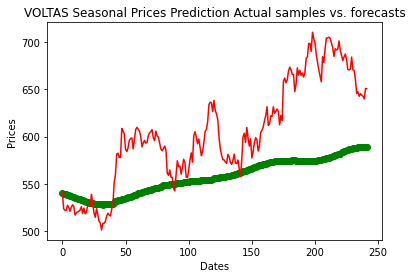

In [102]:
x = np.arange(len(test_1year))
plt.scatter(x, ff_forecast, color='green', marker='o')
plt.plot(x, y_test_1year, color='red', label='Actual Price')
plt.title(stock_ticker + ' Seasonal Prices Prediction Actual samples vs. forecasts')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

In [103]:
autoarima_results = pd.DataFrame(index = ['mae', 'rmse', 'smape'])
autoarima_results['simple'] = [mean_absolute_error(y_test_1year, fc_simple), 
                           sqrt( mean_squared_error(y_test_1year, fc_simple)),
                            smape(y_test_1year, fc_simple)]
autoarima_results['date'] = [mean_absolute_error(y_test_1year, fc_date), 
                            sqrt(mean_squared_error(y_test_1year, fc_date)),
                            smape(y_test_1year, fc_date)]
autoarima_results['date_fourier'] = [mean_absolute_error(y_test_1year, ff_forecast), 
                            sqrt(mean_squared_error(y_test_1year, ff_forecast)),
                            smape(y_test_1year, ff_forecast)]
autoarima_results

,simple,date,date_fourier
mae,54.381837,47.256689,50.023510
rmse,66.055267,58.283302,61.281016
smape,9.091116,7.840413,8.328288


### Cross-Validation

Since we are anyways using auto_arima to come up with the best model parameters, don't need to use CV

## Facebook Prophet

In [153]:
#pystan is must have dependency for fbprophet
#!pip install pystan

You should consider upgrading via the 'd:\programfiles\python\anaconda3\python.exe -m pip install --upgrade pip' command.


In [109]:
#!pip install fbprophet

Processing c:\users\nehac\appdata\local\pip\cache\wheels\ea\0f\9b\c552c9098c5974a9968548eea45adbacaac276327f26724ae6\fbprophet-0.6-py3-none-any.whl


In [106]:
#importing prophet
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [107]:
#Setting up dataset as per fbprophet requirements
pdata = pd.DataFrame() 
pdata['ds'] = data.index
pdata['y'] = data[agg_value_col].values

#Required for  growth = "logistic"
pdata['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata

,ds,y,cap
0,2005-01-03,0.341662,1065.465271
1,2005-01-04,0.338143,1065.465271
2,2005-01-05,0.337305,1065.465271
3,2005-01-06,0.335127,1065.465271
4,2005-01-07,0.332446,1065.465271
...,...,...,...
3682,2019-12-24,643.794128,1065.465271
3683,2019-12-26,642.659302,1065.465271
3684,2019-12-27,639.945374,1065.465271
3685,2019-12-30,650.850403,1065.465271


In [108]:
train_fb = pdata[pdata.ds.dt.year < now.year - 1] 
test_fb = pdata[pdata.ds.dt.year == now.year - 1]  

In [109]:
#fit the model
#model = Prophet(weekly_seasonality=False)
model = Prophet()
model.fit(train_fb)

#Below line adds the prediction modeling to training dataset as well
#close_prices = model.make_future_dataframe(periods=len(test_fb))
#past + future predictions
#fc_all = model.predict(close_prices)

#future predictions
fc_default = model.predict(test_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


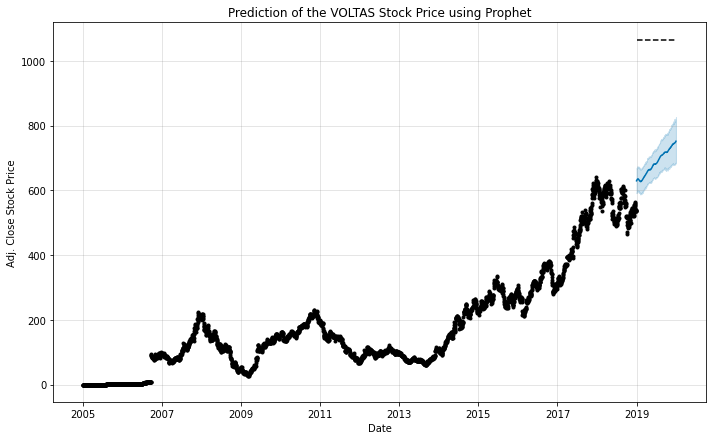

In [110]:
model.plot(fc_default)
plt.title("Prediction of the " + stock_ticker + " Stock Price using Prophet")
plt.xlabel("Date")
plt.ylabel("Adj. Close Stock Price")
plt.show()

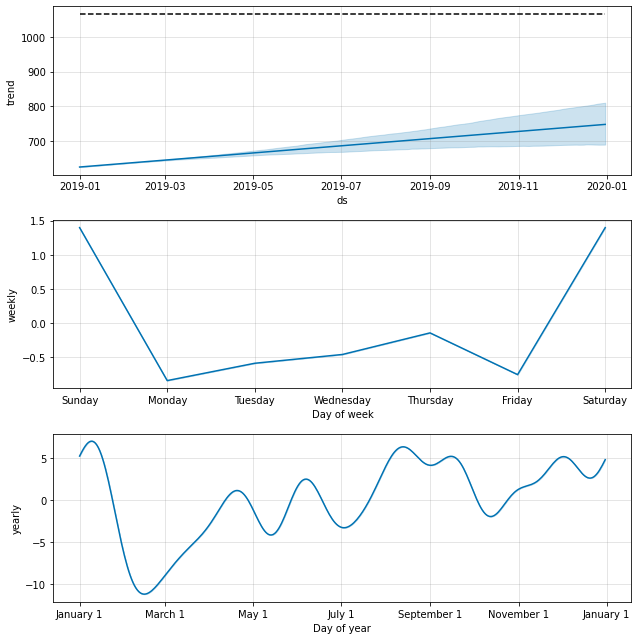

In [111]:
model.plot_components(fc_default)
plt.show()

In [112]:
print(f"Yearly Min-Max: {fc_default.yearly.min(), fc_default['yearly'].max()}")
print(f"Weekly Min-Max: {fc_default.weekly.min(), fc_default['weekly'].max()}")

Yearly Min-Max: (-11.215244377640675, 6.979780075446481)
Weekly Min-Max: (-0.8430584153518347, -0.1446942460051002)


###### Prophet Hyper-parameter tuning

In [113]:
#growth = "linear" or "logistic" to specify a linear or logistic trend.
#yearly.seasonality, weekly.seasonality, daily.seasonality  = "auto", TRUE, FALSE or a number of Fourier terms to generate.
#seasonality_mode = "additive" (default) or "multiplicative"

In [114]:
#fit the model
model = Prophet(weekly_seasonality=False)
model.fit(train_fb)

#future predictions
fc_yearly = model.predict(test_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minor improvements observed on weekly_seasonality=False

In [115]:
#fit the model
model = Prophet(yearly_seasonality = True, weekly_seasonality=False, growth = "logistic")
model.fit(train_fb)

#future predictions
fc_yearly_log = model.predict(test_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Major degradation observed on growth = "logistic" with very high value of cap<br>
Minor improvements observed on growth = "logistic" with Capping the price growth at 50% of max. value

In [116]:
#fit the model
model = Prophet(seasonality_mode = "multiplicative")
model.fit(train_fb)

#future predictions
fc_mul = model.predict(test_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
#fit the model
model = Prophet(weekly_seasonality=False, growth = "logistic", seasonality_mode = "multiplicative")
model.fit(train_fb)

#future predictions
fc_mul_yearly_log = model.predict(test_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
prophet_results = pd.DataFrame(index = ['mae', 'rmse', 'smape'])
prophet_results['default'] = [mean_absolute_error(y_test_1year, fc_default.yhat), 
                            sqrt(mean_squared_error(y_test_1year, fc_default.yhat)),
                            smape(y_test_1year, fc_default.yhat)]
prophet_results['fc_yearly'] = [mean_absolute_error(y_test_1year, fc_yearly.yhat), 
                           sqrt( mean_squared_error(y_test_1year, fc_yearly.yhat)),
                            smape(y_test_1year, fc_yearly.yhat)]
prophet_results['fc_yearly_log'] = [mean_absolute_error(y_test_1year, fc_yearly_log.yhat), 
                            sqrt(mean_squared_error(y_test_1year, fc_yearly_log.yhat)),
                            smape(y_test_1year, fc_yearly_log.yhat)]
prophet_results['fc_mul'] = [mean_absolute_error(y_test_1year, fc_mul.yhat), 
                            sqrt(mean_squared_error(y_test_1year, fc_mul.yhat)),
                            smape(y_test_1year, fc_mul.yhat)]
prophet_results['fc_mul_yearly_log'] = [mean_absolute_error(y_test_1year, fc_mul_yearly_log.yhat), 
                            sqrt(mean_squared_error(y_test_1year, fc_mul_yearly_log.yhat)),
                            smape(y_test_1year, fc_mul_yearly_log.yhat)]
prophet_results

,default,fc_yearly,fc_yearly_log,fc_mul,fc_mul_yearly_log
mae,82.257479,81.697195,69.971085,89.828406,71.818706
rmse,87.153851,86.625804,76.047447,97.377177,81.152002
smape,13.011417,12.930571,11.229824,14.111251,11.497994


With all combinations, there is always as degradation observed with seasonality_mode = "multiplicative"

Best ouptut is obtained for yearly, logistic growth i.e. weekly_seasonality=False, growth = "logistic"

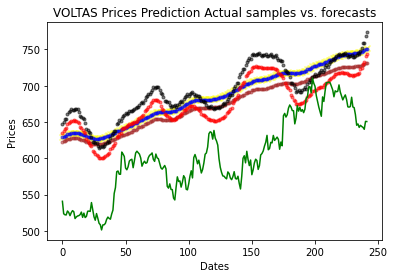

In [119]:
x = np.arange(len(test_fb))
plt.scatter(x, fc_default.yhat, color='yellow', alpha=0.5, marker='x')
plt.scatter(x, fc_yearly.yhat, color='blue', alpha=0.5, marker='.')
plt.scatter(x, fc_yearly_log.yhat, color='brown', alpha=0.5, marker='.')
plt.scatter(x, fc_mul.yhat, color='black', alpha=0.5, marker='.')
plt.scatter(x, fc_mul_yearly_log.yhat, color='red', alpha=0.5, marker='.')
plt.plot(x, test_fb.y, color='green', label='Actual Price')
plt.title(stock_ticker + ' Prices Prediction Actual samples vs. forecasts')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

In [120]:
pd.concat([hwes_results, autoarima_results, prophet_results], axis=1)

,add_None,mul_None,add_add,mul_add,add_mul,simple,date,date_fourier,default,fc_yearly,fc_yearly_log,fc_mul,fc_mul_yearly_log
mae,51.659199,55.014437,71.767178,71.703996,297.667854,54.381837,47.256689,50.023510,82.257479,81.697195,69.971085,89.828406,71.818706
rmse,63.032040,66.786826,86.368641,86.191683,307.778394,66.055267,58.283302,61.281016,87.153851,86.625804,76.047447,97.377177,81.152002
smape,8.611303,9.203187,12.233068,12.221682,69.166650,9.091116,7.840413,8.328288,13.011417,12.930571,11.229824,14.111251,11.497994


Based on above results, best models for different algorithms are as follows:
<ul>
    <li>HWES: trend='add', seasonal=None i.e Add_none, forecast_an</li>
    <li>AutoArima: date i.e. ARIMA(0,1,2)(0,0,0)[0] with date parts as exogenous features</li>
    <li>Prophet: yearly, logistic growth i.e. weekly_seasonality=False, growth = "logistic", fc_yearly_log </li>
</ul>

### Predict the best time of the year to invest based on price prediction

In [122]:
price_pred = test_1year[[group_by_col, agg_value_col]]
#algos = ['hwes', 'aa', 'prophet']
algos = ['hwes_an', 'hwes_mn', 'hwes_aa','hwes_am','hwes_ma',
         'aa_simple', 'aa_date', 'aa_fourier',
         'fb_default', 'fb_yearly','fb_mul','fb_yearly_log','fb_mul_yearly_log']
price_pred.insert(len(price_pred.columns), algos[0] + '_fcast', forecast_an)
price_pred.insert(len(price_pred.columns), algos[1] + '_fcast', forecast_mn)
price_pred.insert(len(price_pred.columns), algos[2] + '_fcast', forecast_aa)
price_pred.insert(len(price_pred.columns), algos[3] + '_fcast', forecast_am)
price_pred.insert(len(price_pred.columns), algos[4] + '_fcast', forecast_ma)
price_pred.insert(len(price_pred.columns), algos[5] + '_fcast', fc_simple)
price_pred.insert(len(price_pred.columns), algos[6] + '_fcast', fc_date)
price_pred.insert(len(price_pred.columns), algos[7] + '_fcast', ff_forecast)
price_pred.insert(len(price_pred.columns), algos[8] + '_fcast', fc_default.yhat.values)
price_pred.insert(len(price_pred.columns), algos[9] + '_fcast', fc_yearly.yhat.values)
price_pred.insert(len(price_pred.columns), algos[10] + '_fcast', fc_mul.yhat.values)
price_pred.insert(len(price_pred.columns), algos[11] + '_fcast', fc_yearly_log.yhat.values)
price_pred.insert(len(price_pred.columns), algos[12] + '_fcast', fc_mul_yearly_log.yhat.values)
price_pred

,year,adj_close,hwes_an_fcast,hwes_mn_fcast,hwes_aa_fcast,hwes_am_fcast,hwes_ma_fcast,aa_simple_fcast,aa_date_fcast,aa_fourier_fcast,fb_default_fcast,fb_yearly_fcast,fb_mul_fcast,fb_yearly_log_fcast,fb_mul_yearly_log_fcast
date,,,,,,,,,,,,,,,
2019-01-01,2019,540.805176,538.923178,538.884066,538.831547,659.818777,538.813313,538.915690,539.493820,540.023596,629.536014,629.211857,647.136214,622.968416,635.132712
2019-01-02,2019,523.669128,539.089580,539.017647,538.477512,686.926595,538.500733,538.790684,539.575770,539.616013,630.341362,629.891974,650.479342,623.575900,637.582391
2019-01-03,2019,522.208740,539.255981,539.151261,536.361212,544.012955,536.425203,538.608356,539.714999,539.255038,631.322326,630.560875,654.225915,624.171891,639.936056
2019-01-04,2019,522.014038,539.422383,539.284909,539.333924,387.925832,539.428876,538.419526,539.854228,538.864086,631.355846,631.209838,654.255572,624.747899,642.162260
2019-01-07,2019,527.466370,539.588785,539.418589,539.779831,261.359208,540.018876,538.255245,540.053354,538.503491,632.995608,632.952450,660.425844,626.274397,647.788753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,2019,643.794128,578.360425,571.487066,537.972565,530.741390,537.081604,573.479178,586.756876,588.909523,747.651734,746.998538,752.171373,727.981152,724.802760
2019-12-26,2019,642.659302,578.526827,571.628728,539.127648,542.130066,538.180029,573.634858,587.035334,589.074096,749.127074,748.022518,759.493999,728.798811,729.611271
2019-12-27,2019,639.945374,578.693229,571.770426,538.834654,533.195269,537.820449,573.790538,587.174563,589.058269,749.090248,748.594658,759.435528,729.267382,732.251595


In [123]:
output = year_agg_data.loc[year_agg_data.index >= now.year - test_data_years, 
                           ['min_adj_close', 'min_sma', 'date_min_sma', 'doy_min_sma']]
for algo in algos:
    output.insert(len(output.columns), 'min_'+ algo + '_fcast', 
                  price_pred.groupby(group_by_col)[algo + '_fcast'].min())
    output.insert(len(output.columns), 'date_min_'+ algo + '_fcast', 
                  price_pred.groupby(group_by_col)[algo + '_fcast'].idxmin())
    output.insert(len(output.columns), 'doy_min_'+ algo + '_fcast', 
                  price_pred.groupby(group_by_col)[algo + '_fcast'].idxmin().dt.dayofyear )

#Drop un-available result rows
output = output.dropna(how = 'any')
output.transpose()

year,2019
min_adj_close,501.373
min_sma,507.371
date_min_sma,2019-02-15 00:00:00
doy_min_sma,46
min_hwes_an_fcast,538.923
date_min_hwes_an_fcast,2019-01-01 00:00:00
doy_min_hwes_an_fcast,1
min_hwes_mn_fcast,538.884
date_min_hwes_mn_fcast,2019-01-01 00:00:00
doy_min_hwes_mn_fcast,1


Above output clearly indicates that while the prdiction accuracy of HWES and AutoArima models is better than Prophet, they are not able to predict the seasonality accurately.

The above output also indicates that, for our problem we should not dicard the seasonality aspect of the alogorithm in deriving the best investment time of the year.

In [138]:
metrics = ['mae', 'pct_err']
output_metrics = pd.DataFrame(columns = metrics, index = algos)
for algo in algos:   
    mae = mean_absolute_error(output.doy_min_sma, output['doy_min_'+ algo + '_fcast'])
    #rmse = sqrt(mean_squared_error(output.doy_min_sma, output['doy_min_'+ algo + '_fcast']))
    pct_err = mean_absolute_error(output.doy_min_sma, output['doy_min_'+ algo + '_fcast']) * 100 / 365.25
    output_metrics.loc[algo] = [mae, pct_err]    
output_metrics

,mae,pct_err
hwes_an,45,12.3203
hwes_mn,45,12.3203
hwes_aa,4,1.09514
hwes_am,25,6.84463
hwes_ma,4,1.09514
aa_simple,36,9.85626
aa_date,45,12.3203
aa_fourier,0,0
fb_default,7,1.9165
fb_yearly,7,1.9165


Whenever sesonality is considered, the acuracy of Prediction is high.<br>
Best 3 models:
<ol>
    <li>Best accuracy of predicting the investment time of year using HWES (T:Add/Mul, S:Add): <font color="red">4 days, 99%</font></li>
    <li>Best accuracy of predicting the investment time of year using AutoArima (using Fourier Featurizer) : <font color="red">0 days, 100%</font></li>
    <li>Best accuracy of predicting the investment time of year using Prophet (T:Logistic, S:Mul): <font color="red">1 day, 99.7%</font></li>
</ol>

### Predict the best time of the year to invest based on seasonal decompose

In [279]:
seasonality = pd.concat([sd_add, sd_mul], axis=1)
sd_1year = seasonality[seasonality.index.year == seasonality.index.year.max()]  
sd_1year.insert(len(sd_1year.columns), group_by_col, sd_1year.index.year)
sd_1year

,sm_sd_add,pm_sd_add,sm_sd_mul,pm_sd_mul,year
date,,,,,
2018-01-01,7.851885,8.082584,1.075419,1.032407,2018
2018-01-02,7.213278,7.442648,1.072177,1.029283,2018
2018-01-03,4.576322,4.807345,1.065926,1.023295,2018
2018-01-04,7.344801,7.575740,1.080769,1.037539,2018
2018-01-05,7.529238,7.758923,1.079192,1.036715,2018
...,...,...,...,...,...
2018-12-24,6.728766,6.958497,1.072888,1.030016,2018
2018-12-26,7.918888,8.148282,1.078179,1.035096,2018
2018-12-27,9.651476,9.882993,1.083859,1.040541,2018


In [283]:
sd_methods = list(seasonality.columns)
sd_methods

['sm_sd_add', 'pm_sd_add', 'sm_sd_mul', 'pm_sd_mul']

In [277]:
y_metrics = ['min', 'date_min', 'doy_min', 'mae', 'pct_err']
actual_date_min = pd.Timestamp(year_agg_data[-1:][y_metrics[1] + '_' + agg_value_col_sma].values[0])
actual_doy_min = year_agg_data[-1:][y_metrics[2] + '_' + agg_value_col_sma].values[0]
actual_date_min, actual_doy_min

(Timestamp('2019-02-15 00:00:00'), 46)

In [280]:
sd_metrics = pd.DataFrame(columns = y_metrics, index = sd_methods)
for method in sd_methods:
    minval = sd_1year.groupby(group_by_col)[method].min().values[-1] ## [0]
    date_min = pd.Timestamp(sd_1year.groupby(group_by_col)[method].idxmin().values[-1]) ## [0]
    doy_min = sd_1year.groupby(group_by_col)[method].idxmin().dt.dayofyear.values[-1] ## [0]
    sd_metrics.loc[method] = [minval, date_min, doy_min, 
                              abs(actual_doy_min - doy_min),
                              abs(actual_doy_min - doy_min) * 100 / 365.25
                             ] 
sd_metrics

,min,date_min,doy_min,mae,pct_err
sm_sd_add,-18.5097,2018-02-20 00:00:00,51,5,1.36893
pm_sd_add,-18.2638,2018-02-20 00:00:00,51,5,1.36893
sm_sd_mul,0.916371,2018-02-23 00:00:00,54,8,2.19028
pm_sd_mul,0.879924,2018-02-23 00:00:00,54,8,2.19028


The above results indicate that with 1 year prior data:
<br> Output derived from sesonal decompose is almost similar to prediction based output but not the best
<br> It will be slightly in-accurate due to day/date/week variations on year on year basis. However, this is going to be the actual scenario
<br> Best Accuracy of predicting the best time of year from Seasonal decompose: <font color="red">5 days, 98.6%</font>

When the same analysis is done on full data:
<br> Best Accuracy of predicting the best time of year from Seasonal decompose: <font color="red">4 days, 99%</font>
<br> However, this does not matter since the actual prod scenario will not be like this.

In [300]:
fb_yearly = test_1year[[group_by_col, agg_value_col]]
fb_methods = ['fb_default', 'fb_yearly','fb_mul','fb_yearly_log','fb_mul_yearly_log']
sd_methods.extend(fb_methods)
fb_yearly.insert(len(fb_yearly.columns), fb_methods[0] + '_yrly', fc_default.yearly.values)
fb_yearly.insert(len(fb_yearly.columns), fb_methods[1] + '_yrly', fc_yearly.yearly.values)
fb_yearly.insert(len(fb_yearly.columns), fb_methods[2] + '_yrly', fc_mul.yearly.values)
fb_yearly.insert(len(fb_yearly.columns), fb_methods[3] + '_yrly', fc_yearly_log.yearly.values)
fb_yearly.insert(len(fb_yearly.columns), fb_methods[4] + '_yrly', fc_mul_yearly_log.yearly.values)
fb_yearly

,year,adj_close,fb_default_yrly,fb_yearly_yrly,fb_mul_yrly,fb_yearly_log_yrly,fb_mul_yearly_log_yrly
date,,,,,,,
2019-01-01,2019,540.805176,5.037785,5.075285,0.152075,4.845553,0.024842
2019-01-02,2019,523.669128,5.377397,5.419164,0.174376,5.138709,0.028272
2019-01-03,2019,522.208740,5.705176,5.751828,0.195837,5.420434,0.031544
2019-01-04,2019,522.014038,6.012499,6.064553,0.216132,5.682236,0.034607
2019-01-07,2019,527.466370,6.728220,6.798451,0.267007,6.266491,0.042085
...,...,...,...,...,...,...,...
2019-12-24,2019,643.794128,2.790814,2.825048,-0.021982,2.995975,-0.002761
2019-12-26,2019,642.659302,3.147232,3.176552,0.014096,3.252624,0.003080
2019-12-27,2019,639.945374,3.384209,3.412455,0.034301,3.440874,0.006321


In [302]:
fb_metrics = pd.DataFrame(columns = y_metrics, index = fb_methods)
for method in fb_methods:
    minval = fb_yearly.groupby(group_by_col)[method + '_yrly'].min().values[-1] ## [0]
    date_min = pd.Timestamp(fb_yearly.groupby(group_by_col)[method + '_yrly'].idxmin().values[-1]) ## [0]
    doy_min = fb_yearly.groupby(group_by_col)[method + '_yrly'].idxmin().dt.dayofyear.values[-1] ## [0]
    fb_metrics.loc[method] = [minval, date_min, doy_min, 
                              abs(actual_doy_min - doy_min),
                              abs(actual_doy_min - doy_min) * 100 / 365.25
                             ] 
fb_metrics

,min,date_min,doy_min,mae,pct_err
fb_default,-11.2152,2019-02-15 00:00:00,46,0,0
fb_yearly,-11.1293,2019-02-15 00:00:00,46,0,0
fb_mul,-0.297104,2019-10-11 00:00:00,284,238,65.1608
fb_yearly_log,-12.1067,2019-02-15 00:00:00,46,0,0
fb_mul_yearly_log,-0.0527861,2019-02-15 00:00:00,46,0,0


The above results indicate that with 1 year prior data:
<br> Prophet precition based output and yearly seasonality based output are different, esp. for multiplicative mode
<br> Best Accuracy of predicting the best time of year from Prophet yearly pattern: <font color="red">0 days, 100%</font>

Notes:
<ol>
    <li>Since data is going to be widely different for each stock, we need to do anlysis and model fitting separately for each stock</li>
    <li>Since this is going to be an yearly exercise, or at best a monthly exercise, we will have to re-run this exercise every year with latest data</li>
    <li>Use 5 algorithms and 5 basic variations of each of them</li>
    <li>Compare the avg. and best price prediction accuracy of last 5 years for all the above variations</li>
    <li>Select the top 5 models below 10% SMAPE error</li>
    <li>Use the top 5 models output to predict the best time period for investment</li> 
    <li>Get the average, with yearly round off for values close to start and end of year. For avg. above 365 subtract 365</li>
    <li>Check the accuracy of individual and average best invesment day prediction against actual sma based value using SMAPE</li>
    <li>Use the top 3 models for next year's best invesment day prediction</li>
</ol>

Remember: 
    SMAPE = 2 * (actual - pred) / (actual + pred)
    
SMAPE is not a good accuracy metric for our scenario will be larger for values near to start of year as compare to values at end of year with the same value of absolute diff. in predicted and actual values.